In [26]:
import pandas as pd

hypo = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')

hypo.columns = (
    hypo.columns
        .str.replace('\x03', '', regex=False)   # quita el carácter ETX
        .str.strip()
        .str.lower()
)

print(hypo.columns.tolist())

['hypothesis', 'reach', 'impact', 'confidence', 'effort']


In [27]:
# ICE
hypo['ice'] = (hypo['impact'] * hypo['confidence']) / hypo['effort']
ice_ranked = hypo.sort_values('ice', ascending=False).reset_index(drop=True)

# RICE
hypo['rice'] = (hypo['reach'] * hypo['impact'] * hypo['confidence']) / hypo['effort']
rice_ranked = hypo.sort_values('rice', ascending=False).reset_index(drop=True)

ice_ranked['ice_rank']   = ice_ranked.index + 1
rice_ranked['rice_rank'] = rice_ranked.index + 1
comparison = (
    ice_ranked[['hypothesis','ice_rank']]
      .merge(rice_ranked[['hypothesis','rice_rank']], on='hypothesis')
      .assign(rank_shift=lambda df: df['ice_rank'] - df['rice_rank'])
      .sort_values('rice_rank')
)

display(comparison)

,hypothesis,ice_rank,rice_rank,rank_shift
2,Add a subscription form to all the main pages....,3,1,2
4,Add product recommendation blocks to the store...,5,2,3
1,Add two new channels for attracting traffic. T...,2,3,-1
3,Show banners with current offers and sales on ...,4,4,0
0,Launch a promotion that gives users discounts ...,1,5,-4
7,Change the category structure. This will incre...,8,6,2
5,Launch your own delivery service. This will sh...,6,7,-1
6,Add a customer review page. This will increase...,7,8,-1
8,Change the background color on the main page. ...,9,9,0


In [28]:
import pandas as pd
import numpy as np

visits  = pd.read_csv('/datasets/visits_us.csv',  parse_dates=['date'])
orders  = pd.read_csv('/datasets/orders_us.csv',  parse_dates=['date'])

visits.columns  = visits.columns.str.strip().str.lower()
orders.columns  = orders.columns.str.strip().str.lower()

dupes = (
    orders.groupby('visitorid')['group'].nunique()
          .reset_index()
          .query('group > 1')['visitorid']
)
clean_orders = orders[~orders['visitorid'].isin(dupes)].copy()

clean_orders = clean_orders.query('revenue > 0')

In [29]:
daily_revenue = (
    clean_orders.groupby(['date', 'group'])['revenue']
               .sum()
               .reset_index()
)

all_dates  = pd.date_range(daily_revenue['date'].min(),
                           daily_revenue['date'].max())
groups     = daily_revenue['group'].unique()

full_grid = (
    pd.DataFrame({'date': all_dates})
      .assign(key=1)
      .merge(pd.DataFrame({'group': groups, 'key':1}), on='key')
      .drop('key', axis=1)
)

daily_revenue = (
    full_grid.merge(daily_revenue, on=['date','group'], how='left')
             .fillna({'revenue': 0})
             .sort_values(['group','date'])
)

daily_revenue['cum_revenue'] = (
    daily_revenue.groupby('group')['revenue'].cumsum()
)

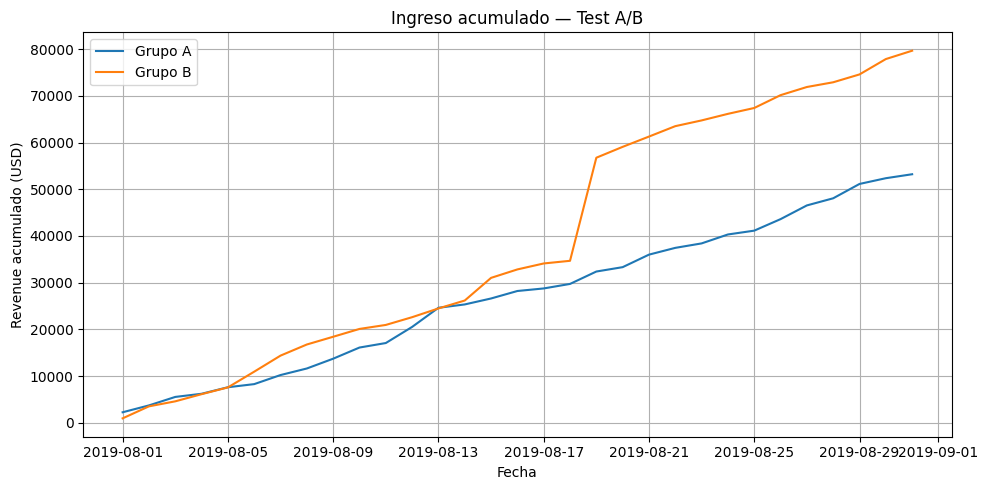

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for grp in daily_revenue['group'].unique():
    subset = daily_revenue.query('group == @grp')
    plt.plot(subset['date'], subset['cum_revenue'], label=f'Grupo {grp}')
    
plt.title('Ingreso acumulado — Test A/B')
plt.xlabel('Fecha')
plt.ylabel('Revenue acumulado (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

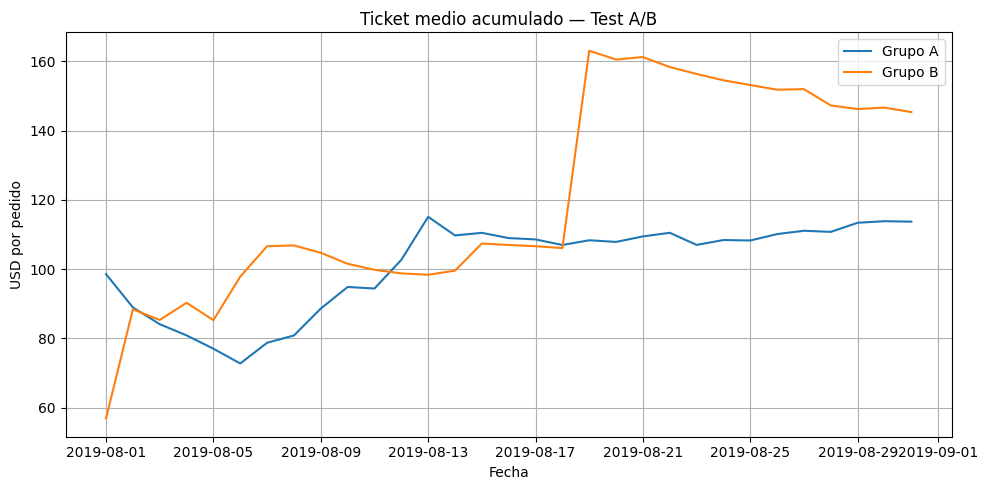

In [31]:
daily_orders = (
    clean_orders
      .groupby(['date','group'])
      .agg(orders=('transactionid','nunique'),
           revenue=('revenue','sum'))
      .reset_index()
)

all_dates  = pd.date_range(daily_orders['date'].min(),
                           daily_orders['date'].max())
groups     = daily_orders['group'].unique()

full_grid = (
    pd.DataFrame({'date': all_dates})
      .assign(key=1)
      .merge(pd.DataFrame({'group': groups, 'key':1}), on='key')
      .drop('key', axis=1)
)

daily_orders = (
    full_grid.merge(daily_orders, on=['date','group'], how='left')
             .fillna({'orders':0, 'revenue':0})
             .sort_values(['group','date'])
)

daily_orders['cum_orders']  = daily_orders.groupby('group')['orders'].cumsum()
daily_orders['cum_revenue'] = daily_orders.groupby('group')['revenue'].cumsum()
daily_orders['cum_avg_check'] = (
    daily_orders['cum_revenue'] / daily_orders['cum_orders'].replace(0, np.nan)
)

plt.figure(figsize=(10,5))
for grp in daily_orders['group'].unique():
    subset = daily_orders.query('group == @grp')
    plt.plot(subset['date'], subset['cum_avg_check'], label=f'Grupo {grp}')

plt.title('Ticket medio acumulado — Test A/B')
plt.xlabel('Fecha')
plt.ylabel('USD por pedido')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

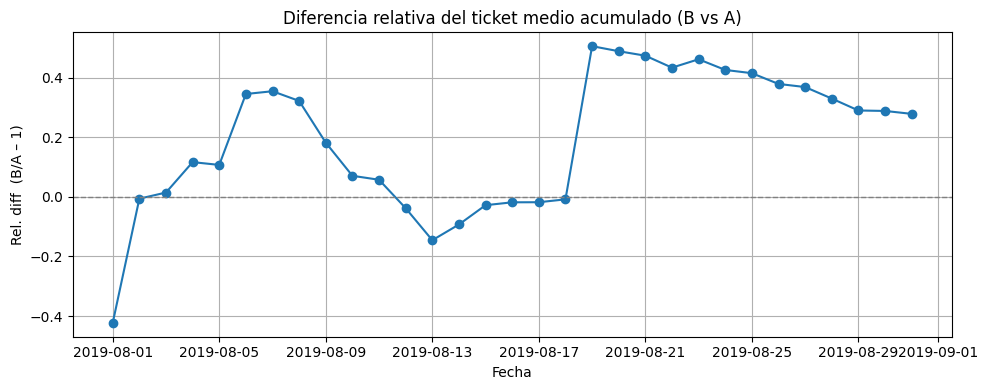

In [32]:
cum_avg = (
    daily_orders.pivot(index='date', columns='group', values='cum_avg_check')
                .rename(columns={'A':'A_cum_avg', 'B':'B_cum_avg'})
)

cum_avg['rel_diff'] = (cum_avg['B_cum_avg'] / cum_avg['A_cum_avg'] - 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(cum_avg.index, cum_avg['rel_diff'], marker='o')
plt.axhline(0, linestyle='--', linewidth=1, color='gray')
plt.title('Diferencia relativa del ticket medio acumulado (B vs A)')
plt.xlabel('Fecha'); plt.ylabel('Rel. diff  (B/A – 1)')
plt.grid(True); plt.tight_layout(); plt.show()

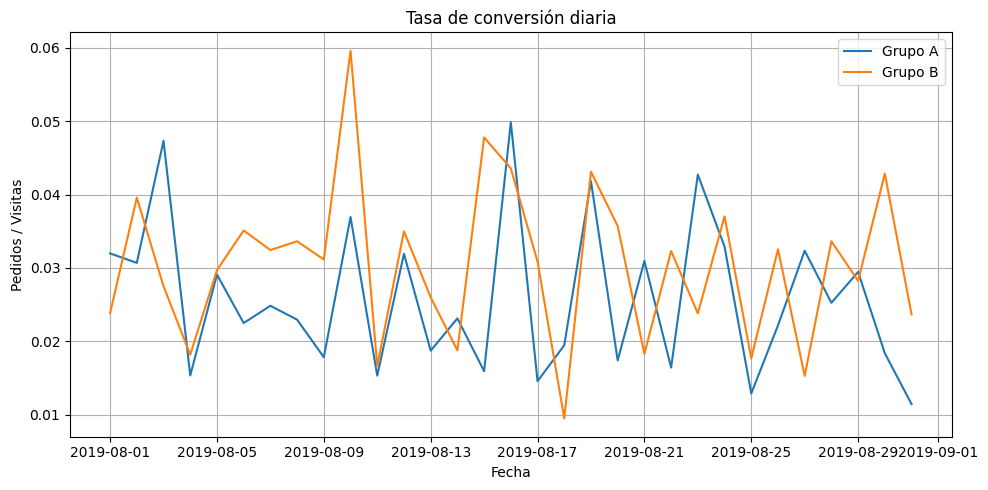

In [33]:
daily_visits = (
    visits.groupby(['date','group'])['visits']
          .sum()
          .reset_index()
)

daily_visits = (
    full_grid.merge(daily_visits, on=['date','group'], how='left')
             .fillna({'visits':0})
             .sort_values(['group','date'])
)

conv_df = (
    daily_orders[['date','group','orders']]
      .merge(daily_visits[['date','group','visits']],
             on=['date','group'])
)
conv_df['conversion'] = conv_df['orders'] / conv_df['visits'].replace(0, np.nan)

plt.figure(figsize=(10,5))
for grp in conv_df['group'].unique():
    subset = conv_df.query('group == @grp')
    plt.plot(subset['date'], subset['conversion'], label=f'Grupo {grp}')

plt.title('Tasa de conversión diaria')
plt.xlabel('Fecha'); plt.ylabel('Pedidos / Visitas')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

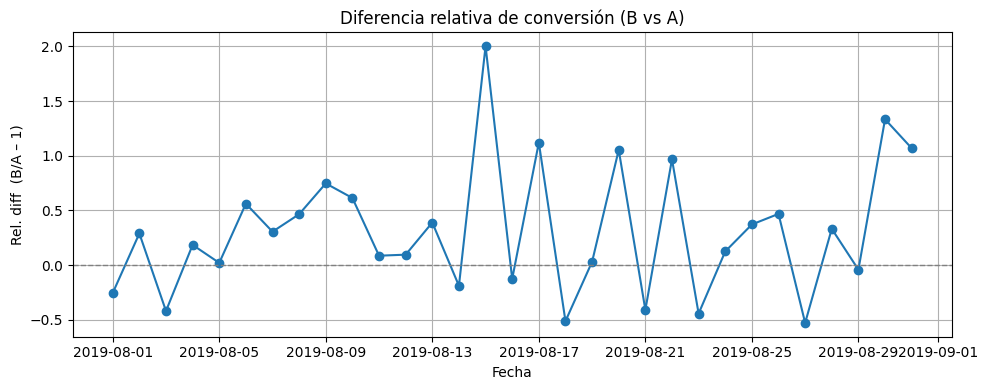

In [34]:
conv_pivot = (
    conv_df.pivot(index='date', columns='group', values='conversion')
           .rename(columns={'A':'A_conv', 'B':'B_conv'})
)
conv_pivot['rel_diff_conv'] = conv_pivot['B_conv'] / conv_pivot['A_conv'] - 1

plt.figure(figsize=(10,4))
plt.plot(conv_pivot.index, conv_pivot['rel_diff_conv'], marker='o')
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title('Diferencia relativa de conversión (B vs A)')
plt.xlabel('Fecha'); plt.ylabel('Rel. diff  (B/A – 1)')
plt.grid(True); plt.tight_layout(); plt.show()

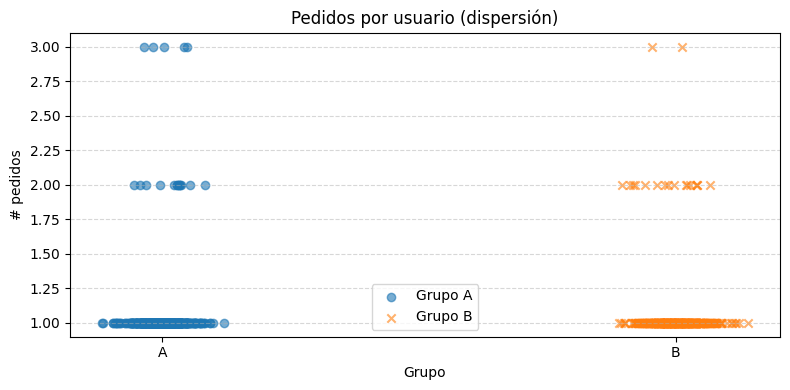

In [35]:
import matplotlib.pyplot as plt

orders_per_user = (
    clean_orders
      .groupby(['visitorid','group'])['transactionid']
      .nunique()
      .reset_index()
      .rename(columns={'transactionid':'orders'})
)

plt.figure(figsize=(8,4))
for grp, color, marker in [('A','blue','o'), ('B','orange','x')]:
    subset = orders_per_user.query('group == @grp')
    x = np.random.normal(loc=0 if grp=='A' else 1, scale=0.04, size=len(subset))
    plt.scatter(x, subset['orders'],
                alpha=0.6, label=f'Grupo {grp}', marker=marker)

plt.xticks([0,1], ['A','B'])
plt.title('Pedidos por usuario (dispersión)')
plt.ylabel('# pedidos'); plt.xlabel('Grupo')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()

In [36]:
q95_orders = np.percentile(orders_per_user['orders'], 95)
q99_orders = np.percentile(orders_per_user['orders'], 99)

print(f"Percentil 95: {q95_orders:.0f} pedidos")
print(f"Percentil 99: {q99_orders:.0f} pedidos")

Percentil 95: 1 pedidos
Percentil 99: 2 pedidos


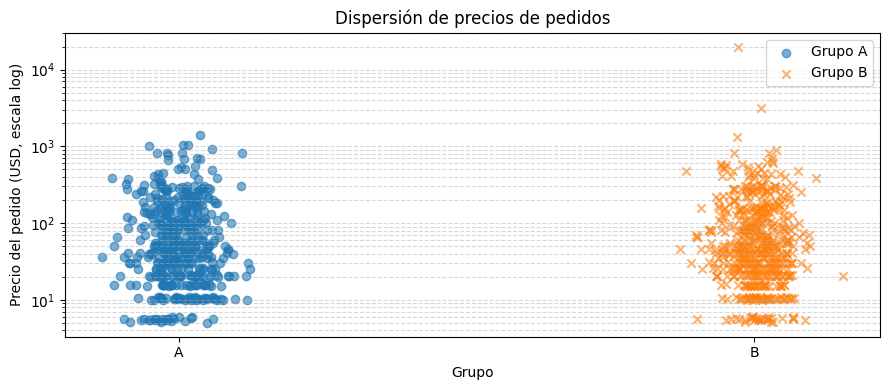

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,4))
for grp, marker in [('A','o'), ('B','x')]:
    subset = clean_orders.query('group == @grp')
    x = np.random.normal(loc=0 if grp=='A' else 1, scale=0.04, size=len(subset))
    plt.scatter(x, subset['revenue'],
                alpha=0.6, marker=marker, label=f'Grupo {grp}')

plt.yscale('log')           
plt.xticks([0,1], ['A','B'])
plt.ylabel('Precio del pedido (USD, escala log)')
plt.xlabel('Grupo')
plt.title('Dispersión de precios de pedidos')
plt.grid(axis='y', which='both', linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()

In [38]:
q95_price = np.percentile(clean_orders['revenue'], 95)
q99_price = np.percentile(clean_orders['revenue'], 99)

print(f"Percentil 95: {q95_price:,.0f} USD")
print(f"Percentil 99: {q99_price:,.0f} USD")

Percentil 95: 414 USD
Percentil 99: 830 USD


In [39]:
from statsmodels.stats.proportion import proportions_ztest

totals = (
    clean_orders.groupby('group')['transactionid'].nunique()
        .rename('orders')
        .to_frame()
        .merge(
            visits.groupby('group')['visits'].sum()
                  .rename('visits')
                  .to_frame(),
            left_index=True, right_index=True
        )
)
print(totals)

count = totals['orders'].values      
nobs  = totals['visits'].values      
stat, p_conv_raw = proportions_ztest(count, nobs, alternative='two-sided')
print(f"\nConversión (bruto)  p-value = {p_conv_raw:.4f}")

       orders  visits
group                
A         468   18736
B         548   18916

Conversión (bruto)  p-value = 0.0169


In [40]:
from scipy import stats

revenue_A = clean_orders.loc[clean_orders['group'] == 'A', 'revenue']
revenue_B = clean_orders.loc[clean_orders['group'] == 'B', 'revenue']

stat, p_avg_raw = stats.mannwhitneyu(revenue_A, revenue_B, alternative='two-sided')
print(f"Ticket medio (bruto)  p-value = {p_avg_raw:.4f}")

Ticket medio (bruto)  p-value = 0.8622


In [42]:
# Usaremos el percentil 99 como corte por defecto

orders_per_user = (
    clean_orders.groupby('visitorid')['transactionid'].nunique()
)
max_orders      = np.percentile(orders_per_user, 99)
print(f"Umbral pedidos/usuario  (p99)  = {max_orders:.0f}")

price_p99 = np.percentile(clean_orders['revenue'], 99)
print(f"Umbral precio pedido    (p99)  = {price_p99:,.0f} USD")


anomalous_users = orders_per_user[orders_per_user > max_orders].index

filtered_orders = clean_orders[
    (~clean_orders['visitorid'].isin(anomalous_users)) &
    (clean_orders['revenue'] <= price_p99)
].copy()

print(f"\nÓrdenes antes: {len(clean_orders):,}   •   después: {len(filtered_orders):,}")

Umbral pedidos/usuario  (p99)  = 2
Umbral precio pedido    (p99)  = 830 USD

Órdenes antes: 1,016   •   después: 986


In [43]:
filt_totals = (
    filtered_orders.groupby('group')['transactionid'].nunique()
          .rename('orders')
          .to_frame()
          .merge(
              visits.groupby('group')['visits'].sum()
                    .rename('visits')
                    .to_frame(),
              left_index=True, right_index=True
          )
)

count_f = filt_totals['orders'].values
nobs_f  = filt_totals['visits'].values

stat, p_conv_filt = proportions_ztest(count_f, nobs_f, alternative='two-sided')
print(f"\nConversión (filtrado)  p-value = {p_conv_filt:.4f}")


Conversión (filtrado)  p-value = 0.0059


In [44]:
revA_f = filtered_orders.loc[filtered_orders['group'] == 'A', 'revenue']
revB_f = filtered_orders.loc[filtered_orders['group'] == 'B', 'revenue']

stat, p_avg_filt = stats.mannwhitneyu(revA_f, revB_f, alternative='two-sided')
print(f"Ticket medio (filtrado)  p-value = {p_avg_filt:.4f}")

Ticket medio (filtrado)  p-value = 0.8220


# Conclusiones y interpretaciones

<div class="alert alert-block alert-info">
<b>Interpretación detallada de cada gráfica</b> <a class="tocSkip"></a>
    
**1. Ingresos acumulados:** Al principio ambas versiones de la tienda (A y B) ganan dinero casi al mismo ritmo. Todo cambia el 18 de agosto, cuando la curva naranja (grupo B) da un salto enorme y se queda por encima de la azul (grupo A) el resto del experimento. Ese salto no refleja una mejora general, sino un solo pedido extraordinariamente caro que apareció en B ese día; sin ese pedido, la diferencia de dinero entre los grupos sería mínima.
    
**2. Ticket medio acumulado:**
El precio promedio por pedido se mantiene muy parecido en los dos grupos a lo largo de toda la prueba. La única excepción es, otra vez, el 18 de agosto, cuando el ticket medio de B se dispara debido al mismo pedido descomunal. Después de ese pico, el promedio de B vuelve a los niveles de A. Esto confirma que, salvo la compra atípica, la gente gasta lo mismo en ambas versiones de la tienda.
    
    
**3. Diferencia relativa del ticket medio:**
Cuando observamos la ventaja porcentual de B sobre A en el ticket medio, la línea está pegada al 0 % la mayor parte del tiempo. Sólo se eleva unos días alrededor del 18 de agosto, coincidiendo con el pedido fuera de lo común. En otras palabras, no hay indicios de que B provoque tickets más altos de forma constante.
    
**4. Conversión diaria:** Las tasas de conversión suben y bajan mucho de un día a otro (algo normal en este tipo de pruebas), pero la línea de B suele situarse ligeramente por encima de la de A. Eso significa que, en la mayoría de los días, una proporción mayor de visitantes de B termina comprando algo.

**5. Diferencia relativa de conversión:** Si miramos la diferencia porcentual entre los grupos, casi todos los puntos están por encima de la línea cero: B supera a A con frecuencia. Aun con la variabilidad diaria, la tendencia general es clara: B convierte más.
    
**6. Pedidos por usuario:** Casi todos los clientes compran una sola vez; sólo un puñado llega a 2 o 3 pedidos y nadie supera los 3. Esto indica que no hay “compradores compulsivos” que distorsionen los resultados. Podemos considerar anómalos los casos que sobrepasen 3 pedidos, pero su impacto es insignificante.

**7. Precios de los pedidos:** La mayoría de los tickets, tanto en A como en B, caen en un rango razonable (de unos pocos dólares hasta 400-500 USD). Sin embargo, en B vemos un punto aislado por encima de 15 000 USD y un par más por encima de 5 000 USD: son los pedidos que provocaron el salto en ingresos. Si eliminamos todos los tickets por encima del 1 % superior (aprox. 450 USD), las distribuciones de precios resultan muy similares entre los grupos.

<div class="alert alert-block alert-info">
<b>Resultados numéricos clave</b> <a class="tocSkip"></a>
    
**- Conversión:** La versión B consigue significativamente más compradores que la A (probabilidad de que esto sea azar < 1 %).
                                                                                                                   
**- Ticket medio:** No hay diferencia significativa; la compra media ronda la misma cantidad en ambos grupos.
                                                                                                                   
Los ingresos extra que vimos en B se explican casi por completo por un único pedido muy grande, no por un cambio real en el comportamiento general de los clientes.

<div class="alert alert-block alert-info">
<b>Conclusión y recomendación</b> <a class="tocSkip"></a>

Resumiendo: la versión B trae más ventas por visita y no cambia cuánto gasta cada cliente en promedio. El gran pico de ingresos fue un caso aislado y no afecta esta conclusión. Por lo tanto, vale la pena detener la prueba y adoptar la versión B para toda la tienda. Tras el lanzamiento, conviene seguir vigilando las métricas un par de semanas para confirmar que la conversión superior se mantiene.